https://www.tableau.com/learn/articles/time-series-analysis

# Description of the project

The main goal of this project is to forecast future values based on historical time-series data.

Also this project demonstrates ability to analyze sequential data and make predictions for planning purposes.

The project ia about air quality. Data received via API of [OpenAQ](https://docs.openaq.org/docs/introduction)

Time series analysis is a specific way of analyzing a sequence of data points collected over an interval of time. Time is a crucial variable because it shows how the data adjusts over the course of the data points as well as the final results. It provides an additional source of information and a set order of dependencies between the data.

Time series forecasting is the process of analyzing time series data using statistics and modeling to make predictions and inform strategic decision-making.

It’s not always an exact prediction, and likelihood of forecasts can vary wildly—especially when dealing with the commonly fluctuating variables in time series data as well as factors outside our control. However, forecasting insight about which outcomes are more likely—or less likely—to occur than other potential outcomes.


Time series analysis involves developing models to gain an understanding of the data to understand the underlying causes. Analysis can provide the “why” behind the outcomes you are seeing. Forecasting then takes the next step of what to do with that knowledge and the predictable extrapolations of what might happen in the future.

# Data retrieving and exploratory analysis

In [388]:
pip install requests

In [389]:
# importing libraries
import requests
import json
import pandas as pd
import numpy as np
import datetime
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline
import seaborn as sns
from pandas import Timestamp
from datetime import datetime, timedelta
import datetime as dt

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller,acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pylab import rcParams

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Air quality parameters

A Parameter in the OpenAQ platform is the type of particle or gaseous pollutant measured. There are plenty of parameters, but in this project we will use only 3 of them:

1. NO₂ mass - Nitrogen Dioxide mass concentration	(µg/m³)
2. SO₂ mass - Sulfur Dioxide mass concentration (µg/m³)
3. CO mass - Carbon Monoxide mass concentration (µg/m³)

[Here](https://docs.openaq.org/docs/parameters) you can find more detailed information about each parameter.

In [390]:
api_key = ""

In [391]:
url_parameters = "https://api.openaq.org/v2/parameters?limit=100&page=1&offset=0&sort=asc&order_by=id"
headers = {"accept": "application/json", "X-API-Key": api_key}
response = requests.get(url_parameters, headers=headers)
data = json.loads(response.text)
df_parameters = pd.DataFrame(data['results'])

In [392]:
df_parameters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             64 non-null     int64 
 1   name           64 non-null     object
 2   displayName    61 non-null     object
 3   description    64 non-null     object
 4   preferredUnit  64 non-null     object
dtypes: int64(1), object(4)
memory usage: 2.6+ KB


In [393]:
list_of_parameters = ['NO₂ mass', 'SO₂ mass','CO mass']

In [394]:
# list of ids of the right ones parameters
id_of_parameters = list(df_parameters[df_parameters['displayName'].isin(list_of_parameters)]['id'].values)

In [395]:
name_of_parameters = list(df_parameters[df_parameters['displayName'].isin(list_of_parameters)]['name'].values)

## Locations of sources

### Countries

Let's see from which coutries we have air quality sources

In [396]:
url_coutries = "https://api.openaq.org/v2/countries?limit=200&page=1&offset=0&sort=asc&order_by=name"
response = requests.get(url_coutries, headers=headers)
data = json.loads(response.text)
df_countries = pd.DataFrame(data['results'])

In [397]:
df_countries.tail()

,code,name,locations,firstUpdated,lastUpdated,parameters,count,cities,sources
108,GB,United Kingdom,482,2016-01-30 01:00:00+00,2024-05-14 10:00:00+00,"[co, co2, humidity, no, no2, nox, o3, pm1, pm1...",61020914,132,9
109,US,United States of America,3921,2016-01-30 01:00:00+00,2024-05-14 10:07:08.844+00,"[bc, co, co2, humidity, no, no2, nox, o3, pm1,...",235322580,776,11
110,UY,Uruguay,1,2023-10-19 22:00:00+00,2023-10-21 10:00:00+00,"[pm25, temperature]",66,0,1
111,UZ,Uzbekistan,1,2018-11-27 22:00:00+00,2024-05-14 10:00:00+00,"[o3, pm25]",75157,1,1
112,VN,Vietnam,40,2016-01-30 01:00:00+00,2024-05-14 10:00:00+00,"[co, no2, o3, pm10, pm25, so2, temperature]",251811,3,6


Before moving on to the next step, we will filter out countries that do not meet the chosen criteria with air quality parameters.

In [398]:
df_countries['mask'] = df_countries['parameters'].apply(lambda x: 1 if all(param in x for param in name_of_parameters) else 0)

In [399]:
df_countries = df_countries[df_countries['mask']==1]

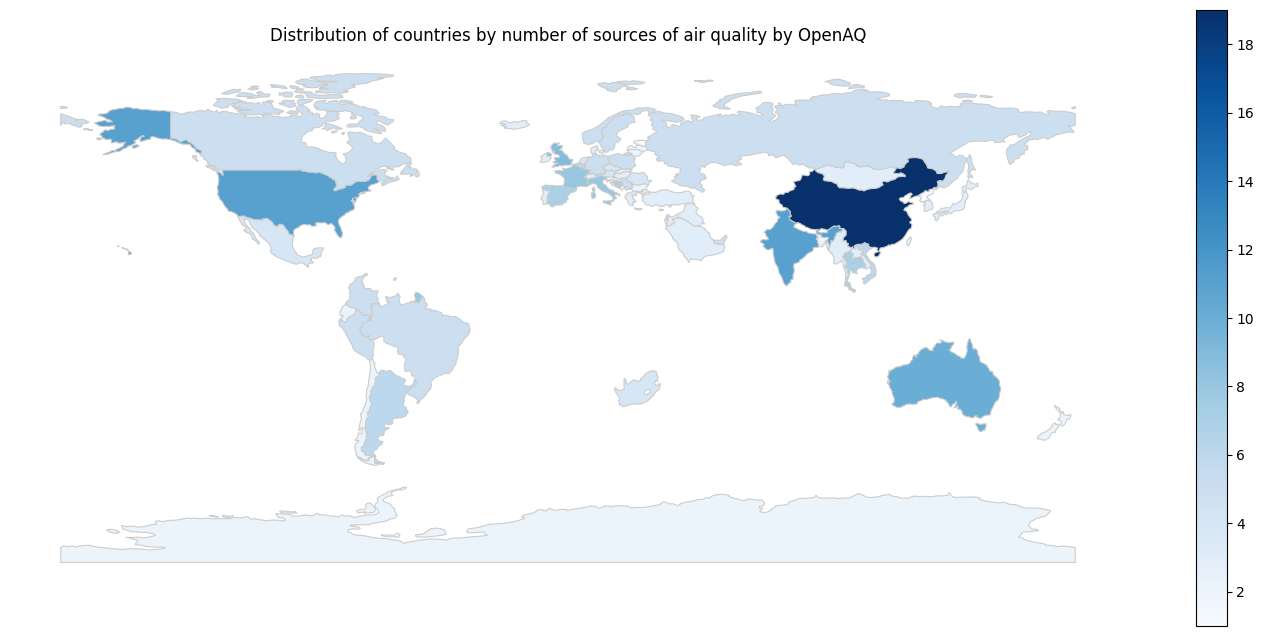

In [400]:
# plotting coutries by number of sources
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.merge(df_countries, how='left', left_on='name', right_on='name')

fig, ax = plt.subplots(1, 1, figsize=(18, 8))
world.plot(column='sources', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
ax.set_title('Distribution of countries by number of sources of air quality by OpenAQ')
ax.set_axis_off()

plt.show()

We see that there are a lot more sources of air quality in China than in other countries.

For further analysis, we decided to focus on European countries.

We will check which countries record our chosen parameters of air quality

In [401]:
# all European countries
european_countries = [
    "Albania",
    "Andorra",
    "Austria",
    "Belarus",
    "Belgium",
    "Bosnia and Herzegovina",
    "Bulgaria",
    "Croatia",
    "Cyprus",
    "Czech Republic",
    "Denmark",
    "Estonia",
    "Finland",
    "France",
    "Germany",
    "Greece",
    "Hungary",
    "Iceland",
    "Ireland",
    "Italy",
    "Kosovo",
    "Latvia",
    "Liechtenstein",
    "Lithuania",
    "Luxembourg",
    "Malta",
    "Moldova",
    "Monaco",
    "Montenegro",
    "Netherlands",
    "North Macedonia",
    "Norway",
    "Poland",
    "Portugal",
    "Romania",
    "Russia",
    "San Marino",
    "Serbia",
    "Slovakia",
    "Slovenia",
    "Spain",
    "Sweden",
    "Switzerland",
    "Ukraine",
    "United Kingdom",
    "Vatican City"
]

In [402]:
# list of codes of the needed countries
code_of_countries = list(df_countries[df_countries['name'].isin(european_countries)]['code'].values)
print(len(code_of_countries))
print(code_of_countries)

31
['AT', 'BE', 'BG', 'HR', 'CY', 'DK', 'EE', 'FR', 'DE', 'GR', 'HU', 'IS', 'IE', 'IT', 'XK', 'LV', 'LT', 'LU', 'ME', 'NL', 'NO', 'PL', 'PT', 'RO', 'RU', 'RS', 'SK', 'ES', 'SE', 'CH', 'GB']


### Locations

Now we will explore locations within chosen countries

In [403]:
df_locations = pd.DataFrame()

In [404]:
for n in range(len(code_of_countries)):
  url = f"https://api.openaq.org/v2/locations?limit=1000&page=1&offset=0&sort=desc&parameter_id={id_of_parameters[0]}&radius=1000&country={code_of_countries[n]}&order_by=lastUpdated&dump_raw=false"
  response = requests.get(url, headers=headers)
  data = json.loads(response.text)
  table = pd.DataFrame(data['results'])
  df_locations = pd.concat([df_locations, table])

In [405]:
for n in range(len(code_of_countries)):
  url = f"https://api.openaq.org/v2/locations?limit=1000&page=1&offset=0&sort=desc&parameter_id={id_of_parameters[1]}&radius=1000&country={code_of_countries[n]}&order_by=lastUpdated&dump_raw=false"
  response = requests.get(url, headers=headers)
  data = json.loads(response.text)
  table = pd.DataFrame(data['results'])
  df_locations = pd.concat([df_locations, table])

In [406]:
for n in range(len(code_of_countries)):
  url = f"https://api.openaq.org/v2/locations?limit=1000&page=1&offset=0&sort=desc&parameter_id={id_of_parameters[2]}&radius=1000&country={code_of_countries[n]}&order_by=lastUpdated&dump_raw=false"
  response = requests.get(url, headers=headers)
  data = json.loads(response.text)
  table = pd.DataFrame(data['results'])
  df_locations = pd.concat([df_locations, table])

Before clearing the dataframe of duplicate records, we will make a list of those indexes that occur 3 times. This IDs of sources where all the parameters we need are measured.

In [407]:
tt = pd.DataFrame(df_locations['id'].value_counts()).reset_index()
ids_source_with_chosen_parameters = list(tt[tt['count']==3]['id'])

In [408]:
df_locations = df_locations[df_locations['id'].isin(ids_source_with_chosen_parameters)]

In [409]:
df_locations['country'].value_counts()

country
ES    759
PL    264
IT    252
HU    189
RS    171
RO    162
DE    144
BG    117
AT     87
RU     63
XK     51
FR     45
SK     45
BE     42
GR     33
CY     27
PT     18
LT     15
CH     15
EE     15
IE     12
HR      9
GB      9
NL      9
ME      9
DK      6
LU      6
IS      3
Name: count, dtype: int64

In [410]:
df_locations = df_locations.drop_duplicates(subset=['id'])

In [411]:
df_locations['country'].value_counts()

country
ES    253
PL     88
IT     84
HU     63
RS     57
RO     54
DE     48
BG     39
AT     29
RU     21
XK     17
FR     15
SK     15
BE     14
GR     11
CY      9
PT      6
LT      5
CH      5
EE      5
IE      4
HR      3
GB      3
NL      3
ME      3
DK      2
LU      2
IS      1
Name: count, dtype: int64

Since this project is aimed at studying time series, we will use those locations that were updated on the day the data was received.

In [414]:
# to start we need to convert types of columns 'lastUpdated' and 'firstUpdated' to datetime
df_locations['lastUpdated'] = pd.to_datetime(df_locations['lastUpdated'])
df_locations['firstUpdated'] = pd.to_datetime(df_locations['firstUpdated'])

In [413]:
from datetime import datetime
date = datetime.now().date()

# filter to include only rows with the today's date as last updated date
df_locations = df_locations[df_locations['lastUpdated'].dt.date == date]

## Creating the dataset

### Date range

First, we will look at dates of first and last updates for our locations. Then we will choose optimal time range. This is important step in Time series analysis.

In [415]:
min_date_intersection = df_locations['firstUpdated'].max().date()
delta = date - min_date_intersection
print(f'Between date_from and date_to: {delta.days} days')

Between date_from and date_to: 1 days


1 day is really low. For our analysis we would like to take data from minimum the last 3 years. Therefore, we will filter source by that condition

In [416]:
# date from which we will retrieve data
date_from = (date - pd.DateOffset(years=3)).date()
# date to which we will retrieve data
date_to = date

In [417]:
# firstUpdated
df_locations = df_locations[df_locations['firstUpdated'].dt.date <= date_from]

In [418]:
min_date_intersection = df_locations['firstUpdated'].max().date()
delta = date - min_date_intersection
print(f'Between date_from and date_to: {delta.days} days')

Between date_from and date_to: 1111 days


1111 days in more than 3 years. Let's continue and select sources

### IDs of locations
We picked a source with the most measurements in each country

In [419]:
ids_sources = list(df_locations.loc[df_locations.groupby('country')['measurements'].transform(max) == df_locations['measurements']]['id'].values)

In [420]:
df_chosen_locations = df_locations[df_locations['id'].isin(ids_sources)]

In [421]:
df_chosen_locations = pd.concat([df_chosen_locations.drop(['coordinates'], axis=1), df_chosen_locations['coordinates'].apply(pd.Series)], axis=1)

Now let's plot our chosen locations on the map

In [422]:
fig = px.scatter_mapbox(df_chosen_locations, lat="latitude", lon="longitude", hover_name="name", hover_data=["country", "city"],
                        color_discrete_sequence=["red"], zoom=2.9, height=400)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_traces(marker=dict(size=14))
fig.show()

### Final dataset

Now all we need to do is retrieve data through url with the chosen parameters:
1. IDs of air quality parameters: NO₂ mass, SO₂ mass, CO mass, O₃ mass
2. IDs of sources in chosen countries
3. Dates: from two years ago till today

We will get averaged daily values aggregated by location

In [423]:
id_of_parameters

[4, 5, 6]

In [424]:
ids_sources

[4603,
 4914,
 8857,
 2974,
 8161,
 5176,
 10624,
 9742,
 4713,
 3965,
 10665,
 9773,
 9588,
 7931,
 8152,
 9651,
 2371,
 10691,
 7173,
 9386,
 10879,
 5205,
 4323,
 9589,
 154]

In [425]:
date_from

datetime.date(2021, 5, 14)

In [426]:
date_to

datetime.date(2024, 5, 14)

In [427]:
df = pd.DataFrame()

In [428]:
def get_data_by_location_average_day(list_of_id_parameters, date_to, date_from, location_id):
  '''
  retrieve data about average per day air quality parameters
  '''
  location_data = pd.DataFrame()
  for i in range(len(list_of_id_parameters)):
    url = f"https://api.openaq.org/v2/averages?temporal=day&parameters_id={list_of_id_parameters[i]}&date_to={date_to}&date_from={date_from}&locations_id={location_id}&spatial=location&limit=1000&page=1"
    response = requests.get(url, headers=headers)
    data = json.loads(response.text)
    if 'results' in data:
      results = data['results']
      table = pd.DataFrame(results)
      location_data = pd.concat([location_data, table])
    try:
      url = f"https://api.openaq.org/v2/averages?temporal=day&parameters_id={list_of_id_parameters[i]}&date_to={date_to}&date_from={date_from}&locations_id={location_id}&spatial=location&limit=1000&page=2"
      response = requests.get(url, headers=headers)
      data = json.loads(response.text)
      if 'results' in data:
        results = data['results']
        table = pd.DataFrame(results)
        location_data = pd.concat([location_data, table])
      else:
        continue
    except:
      continue
    else:
      continue
  return location_data

In [429]:
for i in range(len(ids_sources)):
  location_data = get_data_by_location_average_day(id_of_parameters, date_to, date_from, ids_sources[i])
  df = pd.concat([df, location_data])

In [430]:
df.head()

,id,name,hour,day,month,year,hod,dow,average,measurement_count,parameter,parameterId,displayName,unit,first_datetime,last_datetime
0,4603,Illmitz am Neusiedler See,None,2021-05-14,None,None,None,None,106.090283,7,co,4,CO mass,µg/m³,2021-05-14T16:00:00Z,2021-05-14T23:00:00Z
1,4603,Illmitz am Neusiedler See,None,2021-05-15,None,None,None,None,105.646856,21,co,4,CO mass,µg/m³,2021-05-15T00:00:00Z,2021-05-15T23:00:00Z
2,4603,Illmitz am Neusiedler See,None,2021-05-16,None,None,None,None,98.910899,20,co,4,CO mass,µg/m³,2021-05-16T00:00:00Z,2021-05-16T23:00:00Z
3,4603,Illmitz am Neusiedler See,None,2021-05-17,None,None,None,None,96.213787,19,co,4,CO mass,µg/m³,2021-05-17T00:00:00Z,2021-05-17T23:00:00Z
4,4603,Illmitz am Neusiedler See,None,2021-05-18,None,None,None,None,94.943597,15,co,4,CO mass,µg/m³,2021-05-18T00:00:00Z,2021-05-18T16:00:00Z


In [431]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56581 entries, 0 to 973
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 56581 non-null  int64  
 1   name               56581 non-null  object 
 2   hour               0 non-null      object 
 3   day                56581 non-null  object 
 4   month              0 non-null      object 
 5   year               0 non-null      object 
 6   hod                0 non-null      object 
 7   dow                0 non-null      object 
 8   average            55950 non-null  float64
 9   measurement_count  56581 non-null  int64  
 10  parameter          56581 non-null  object 
 11  parameterId        56581 non-null  int64  
 12  displayName        56581 non-null  object 
 13  unit               56581 non-null  object 
 14  first_datetime     56581 non-null  object 
 15  last_datetime      56581 non-null  object 
dtypes: float64(1), int64(3), obje

In [432]:
df = df.drop_duplicates()

In [433]:
df['id'].value_counts()

id
10879    3035
8161     3011
10691    3001
4603     2983
9773     2959
8857     2929
5176     2873
9742     2845
154      2819
4713     2778
9651     2733
4914     2562
8152     2486
9589     2463
9588     2459
4323     2352
2371     2060
3965     1987
7173     1902
10665    1717
9386     1442
2974     1323
5205     1016
10624     460
7931      386
Name: count, dtype: int64

In [434]:
# save dataframe to .csv format
df.to_csv('air_quality_europe.csv', index=False)

In [435]:
df_final = pd.read_csv('air_quality_europe.csv')
df_final.head()

,id,name,hour,day,month,year,hod,dow,average,measurement_count,parameter,parameterId,displayName,unit,first_datetime,last_datetime
0,4603,Illmitz am Neusiedler See,NaN,2021-05-14,NaN,NaN,NaN,NaN,106.090283,7,co,4,CO mass,µg/m³,2021-05-14T16:00:00Z,2021-05-14T23:00:00Z
1,4603,Illmitz am Neusiedler See,NaN,2021-05-15,NaN,NaN,NaN,NaN,105.646856,21,co,4,CO mass,µg/m³,2021-05-15T00:00:00Z,2021-05-15T23:00:00Z
2,4603,Illmitz am Neusiedler See,NaN,2021-05-16,NaN,NaN,NaN,NaN,98.910899,20,co,4,CO mass,µg/m³,2021-05-16T00:00:00Z,2021-05-16T23:00:00Z
3,4603,Illmitz am Neusiedler See,NaN,2021-05-17,NaN,NaN,NaN,NaN,96.213787,19,co,4,CO mass,µg/m³,2021-05-17T00:00:00Z,2021-05-17T23:00:00Z
4,4603,Illmitz am Neusiedler See,NaN,2021-05-18,NaN,NaN,NaN,NaN,94.943597,15,co,4,CO mass,µg/m³,2021-05-18T00:00:00Z,2021-05-18T16:00:00Z


In [436]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56581 entries, 0 to 56580
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 56581 non-null  int64  
 1   name               56581 non-null  object 
 2   hour               0 non-null      float64
 3   day                56581 non-null  object 
 4   month              0 non-null      float64
 5   year               0 non-null      float64
 6   hod                0 non-null      float64
 7   dow                0 non-null      float64
 8   average            55950 non-null  float64
 9   measurement_count  56581 non-null  int64  
 10  parameter          56581 non-null  object 
 11  parameterId        56581 non-null  int64  
 12  displayName        56581 non-null  object 
 13  unit               56581 non-null  object 
 14  first_datetime     56581 non-null  object 
 15  last_datetime      56581 non-null  object 
dtypes: float64(6), int64(3

In [437]:
# delete hour, hod, measurement_count, first_datetime, last_datetime

df_final.drop(columns=['hour', 'year', 'month', 'dow',
                 'hod', 'measurement_count',
                 'first_datetime', 'last_datetime'], inplace=True)

In [438]:
# column 'day' to datetime type
df_final['day'] = pd.to_datetime(df_final['day'])

In [439]:
# make month column
df_final['month'] = df_final['day'].dt.month

In [440]:
# make year column
df_final['year'] = df_final['day'].dt.year

In [441]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56581 entries, 0 to 56580
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           56581 non-null  int64         
 1   name         56581 non-null  object        
 2   day          56581 non-null  datetime64[ns]
 3   average      55950 non-null  float64       
 4   parameter    56581 non-null  object        
 5   parameterId  56581 non-null  int64         
 6   displayName  56581 non-null  object        
 7   unit         56581 non-null  object        
 8   month        56581 non-null  int32         
 9   year         56581 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(2), int64(2), object(4)
memory usage: 3.9+ MB


In [442]:
df_final.head()

,id,name,day,average,parameter,parameterId,displayName,unit,month,year
0,4603,Illmitz am Neusiedler See,2021-05-14,106.090283,co,4,CO mass,µg/m³,5,2021
1,4603,Illmitz am Neusiedler See,2021-05-15,105.646856,co,4,CO mass,µg/m³,5,2021
2,4603,Illmitz am Neusiedler See,2021-05-16,98.910899,co,4,CO mass,µg/m³,5,2021
3,4603,Illmitz am Neusiedler See,2021-05-17,96.213787,co,4,CO mass,µg/m³,5,2021
4,4603,Illmitz am Neusiedler See,2021-05-18,94.943597,co,4,CO mass,µg/m³,5,2021


In our final dataset we have some null values in `average` column, for further analysis we will remove them.

In [443]:
df_final[df_final['average'].isnull()]['name'].value_counts()

name
Cabauw-Wielsekade    631
Name: count, dtype: int64

In [444]:
df_final[df_final['name']=='Cabauw-Wielsekade'].head()

,id,name,day,average,parameter,parameterId,displayName,unit,month,year
36491,2371,Cabauw-Wielsekade,2021-05-14,12.155000,no2,5,NO₂ mass,µg/m³,5,2021
36492,2371,Cabauw-Wielsekade,2021-05-15,6.130000,no2,5,NO₂ mass,µg/m³,5,2021
36493,2371,Cabauw-Wielsekade,2021-05-16,5.523333,no2,5,NO₂ mass,µg/m³,5,2021
36494,2371,Cabauw-Wielsekade,2021-05-17,10.297143,no2,5,NO₂ mass,µg/m³,5,2021
36495,2371,Cabauw-Wielsekade,2021-05-18,6.947500,no2,5,NO₂ mass,µg/m³,5,2021


In [445]:
df_final = df_final.dropna(subset=['average'])

# Time series analysis

Here we will highlight the main characteristics of the time series data in a visual format and try to identify patterns in the data, like trends, cycles, or seasonal variation.

Here we have information about where located chosen sources (we will be using source id = 'id' in the table below in plotting function)

In [446]:
table_info_sources = df_final[['id', 'name']].drop_duplicates().reset_index(drop=True)
table_info_sources = pd.merge(table_info_sources,
                              df_chosen_locations[['id',
                                                  'country',
                                                  'city',
                                                  'latitude' ,
                                                  'longitude']],
                 on='id', how='left')
table_info_sources

,id,name,country,city,latitude,longitude
0,4603,Illmitz am Neusiedler See,AT,7142 Illmitz,47.770280,16.766390
1,4914,43N060 - HAVINNES,BE,HAVINNES,50.616718,3.457624
2,8857,AMS Vazrazhdane-Ruse,BG,National air network,43.851367,25.964086
3,2974,OSIJEK-1,HR,Osijek,45.558792,18.698769
4,8161,"""NICOSIA RESIDENTIAL""",CY,Strovolos,35.126942,33.331665
5,5176,"""Copenhagen/1103""",DK,Maria,55.674300,12.571100
6,10624,"""Tartu""",EE,Nõo,58.370556,26.734722
7,9742,Escaldes-Engordany,FR,Escaldes-Engordany,42.509694,1.539138
8,4713,Bremerhaven-Hansastraße,DE,Bremerhaven,53.562455,8.569405
9,3965,"""Dunaujvaros""",HU,Dunaújváros,46.976111,18.936114


And here we have information about parameters (we will be using parameter id = 'id' in the table below in plotting function)

In [447]:
table_info_parameters = df_parameters[df_parameters['displayName'].isin(list_of_parameters)]
table_info_parameters

,id,name,displayName,description,preferredUnit
3,4,co,CO mass,Carbon Monoxide mass concentration,µg/m³
4,5,no2,NO₂ mass,Nitrogen Dioxide mass concentration,µg/m³
5,6,so2,SO₂ mass,Sulfur Dioxide mass concentration,µg/m³


In [448]:
# color codes
colors_of_parameters = {4:'#219C90', 5:'#EE9322', 6:'#D83F31'}

In [449]:
parameter_name_by_id = {4:'CO mass', 5:'NO₂ mass', 6:'SO₂ mass'}

For further analysis, we will focus on source in Belgrade, Serbia. However, through the use of functions in the future, we will be able to conduct the same analysis of any other location as well.

In [450]:
id_of_source = 10879

In [451]:
df_final_source = df_final[df_final['id']==id_of_source]

## Trends

In [452]:
def trend_per_day(df, parameter_id):
  '''
  function for plotting average values trend over years
  function takes data and parameter_id
  '''
  plt.figure(figsize=(10,6))
  data = df[df['parameterId']==parameter_id]
  plt.plot(data['day'], data['average'], color=colors_of_parameters[parameter_id], linewidth=1)
  parameter_name = table_info_parameters.loc[table_info_parameters['id']==parameter_id, 'description'].iloc[0]
  country_code = table_info_sources.loc[table_info_sources['id']==id_of_source, 'country'].iloc[0]
  source_name = table_info_sources.loc[table_info_sources['id']==id_of_source, 'name'].iloc[0]
  plt.title(f'Average {parameter_name} per day in {source_name}, {country_code} for the last 3 years')
  plt.xlabel('Date')
  plt.ylabel(f'Daily average {parameter_name}')
  plt.show()

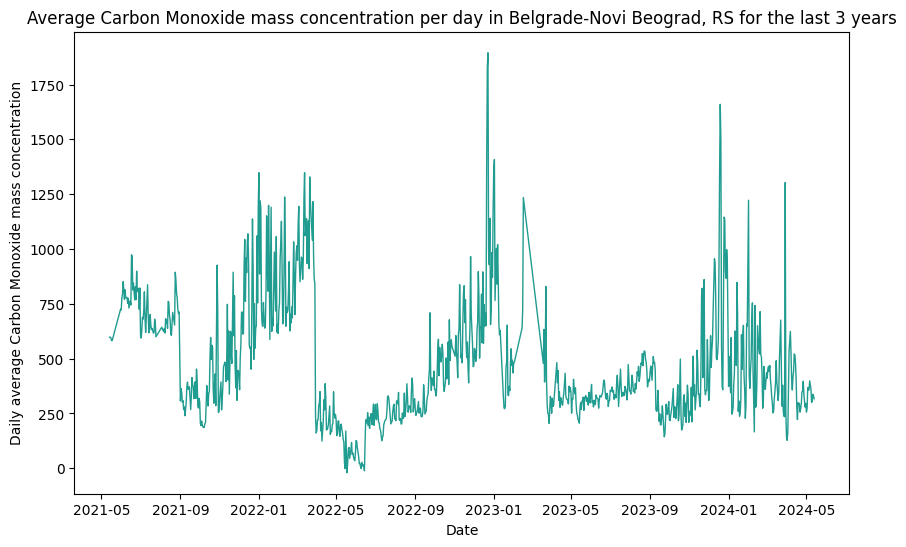

In [453]:
# Carbon monoxide, Serbia
trend_per_day(df_final_source, 4)

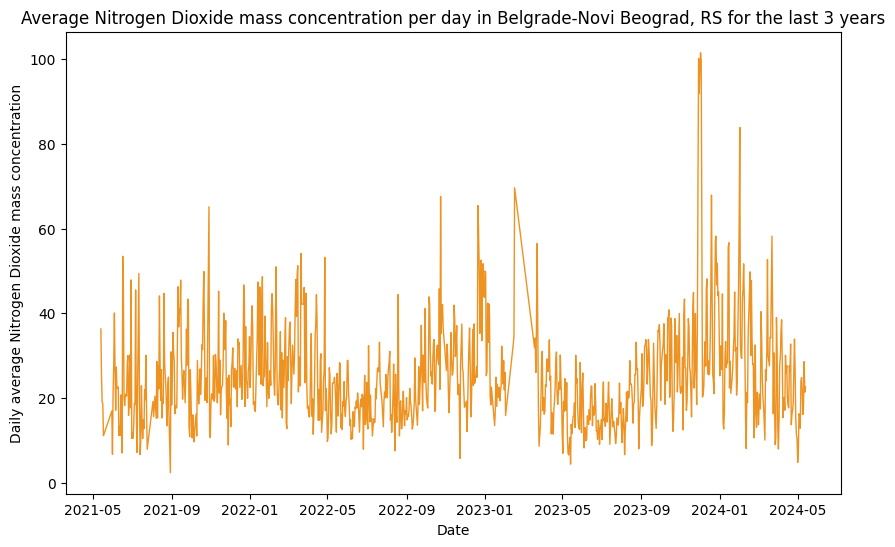

In [454]:
# Nitrogen dioxide, Serbia
trend_per_day(df_final_source, 5)

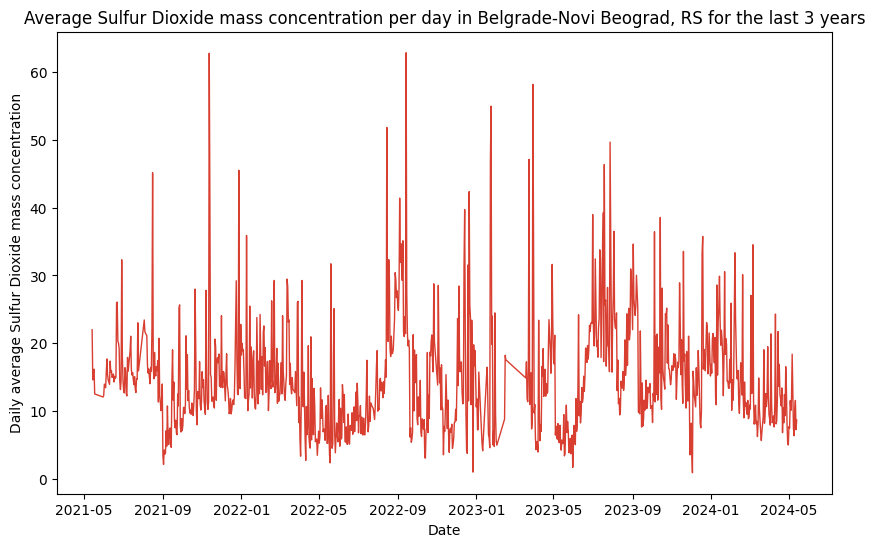

In [455]:
# Sulfur dioxide, Serbia
trend_per_day(df_final_source, 6)

 In the last three charts, we do not see the same cyclicity. Let's study the data further, consider the seasonality.

## Seasonality

In [456]:
def source_data_grouped_by_time_period(data, key, freq, col):
    '''
    groups data by chosen time perios
    and counts mean on 'col' column
    '''
    df_grouped = data.groupby([pd.Grouper(key=key, freq=freq)]).agg(mean=(col,'mean'))
    df_grouped = df_grouped.reset_index()
    return df_grouped

df_final_grouped_month = pd.DataFrame()

for i in range(3,7):
  data = df_final_source[df_final_source['parameterId']==i]
  table = source_data_grouped_by_time_period(data, 'day', 'M', 'average')
  table['parameterId'] = [i for x in range(len(table))]
  df_final_grouped_month = pd.concat([df_final_grouped_month, table])

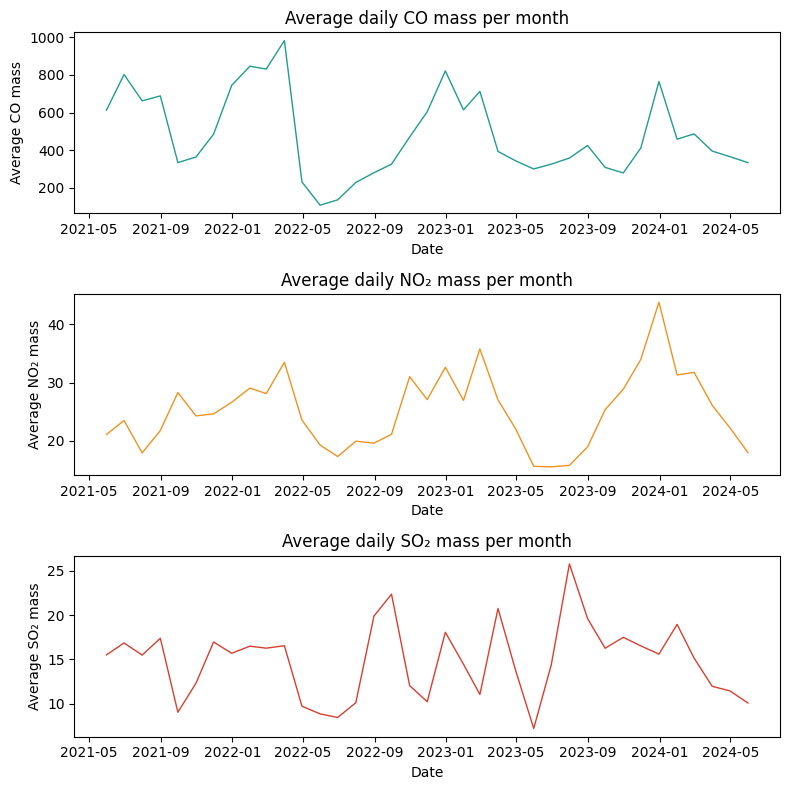

In [457]:
fig, ax = plt.subplots(len(id_of_parameters), figsize=(8, 8))

for i in range(len(id_of_parameters)):
  id_parameter = id_of_parameters[i]
  data = df_final_grouped_month[df_final_grouped_month['parameterId']==id_parameter]
  sns.lineplot(x=data['day'], y=data['mean'], linewidth=1,
               ax=ax[i], color=colors_of_parameters[id_parameter])
  ax[i].set_title(f'Average daily {parameter_name_by_id[id_parameter]} per month')
  ax[i].set(xlabel='Date', ylabel=f'Average {parameter_name_by_id[id_parameter]}')

fig.tight_layout()
plt.show()

In the graphs above we can't see seasons or cycles.

Now, we will do the same procedure but group by week

In [458]:
df_final_grouped_week = pd.DataFrame()

for i in range(3,7):
  data = df_final_source[df_final_source['parameterId']==i]
  table = source_data_grouped_by_time_period(data, 'day', 'W', 'average')
  table['parameterId'] = [i for x in range(len(table))]
  df_final_grouped_week = pd.concat([df_final_grouped_week, table])

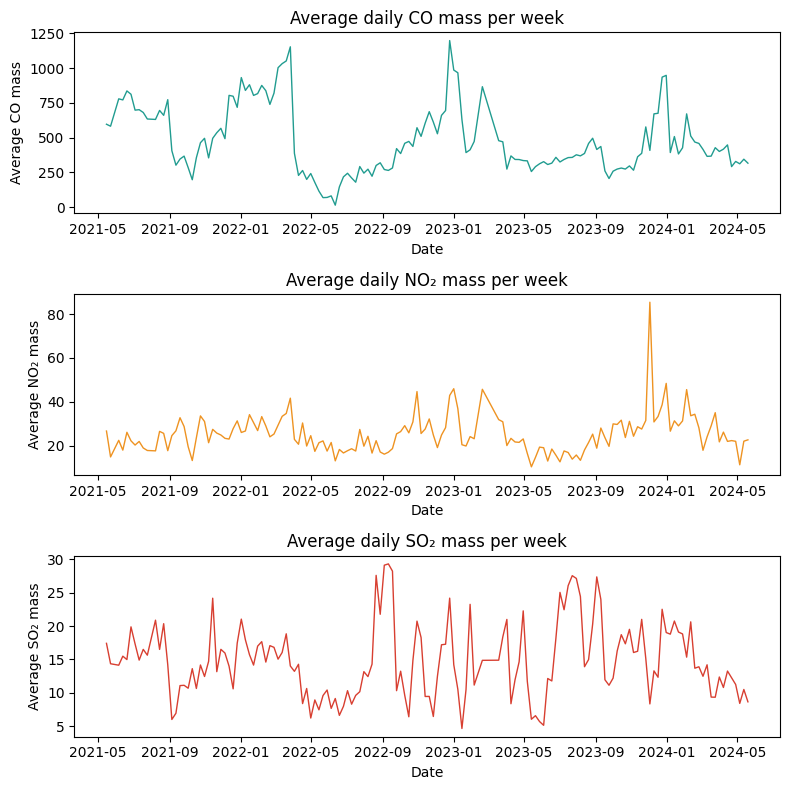

In [459]:
fig, ax = plt.subplots(len(id_of_parameters), figsize=(8, 8))

for i in range(len(id_of_parameters)):
  id_parameter = id_of_parameters[i]
  data = df_final_grouped_week[df_final_grouped_week['parameterId']==id_parameter]
  sns.lineplot(x=data['day'], y=data['mean'], linewidth=1,
               ax=ax[i], color=colors_of_parameters[id_parameter])
  ax[i].set_title(f'Average daily {parameter_name_by_id[id_parameter]} per week')
  ax[i].set(xlabel='Date', ylabel=f'Average {parameter_name_by_id[id_parameter]}')

fig.tight_layout()
plt.show()

 We also do not see pronounced patterns on charts. It can be seen that the indicators of CO and NO2 change at about the same moment, but with different strengths.

## Decomposition of Time Series

Let's use the decomposition technique to deconstruct the time series data into several component like trend and seasonality for visualization of time series characteristics.

Here we are going to use 'additive' model because it is quick to develop, fast to train, and provide interpretable patterns.

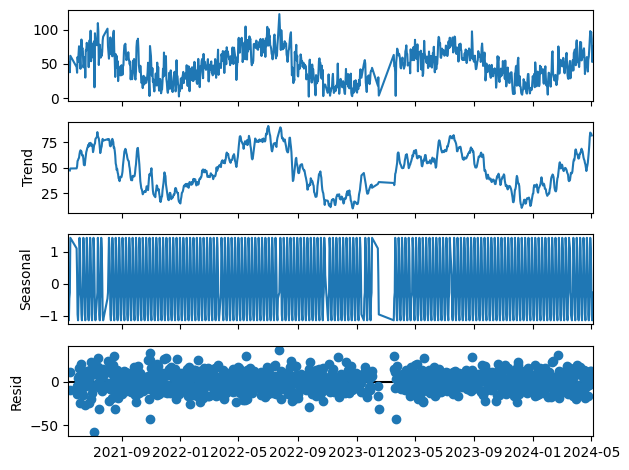

In [191]:
def get_timeseries_data_by_parameter(df, parameter_id):
  table = df_final_source[df_final_source['parameterId']==parameter_id]
  data = table[['day', 'average']].set_index('day')
  return data

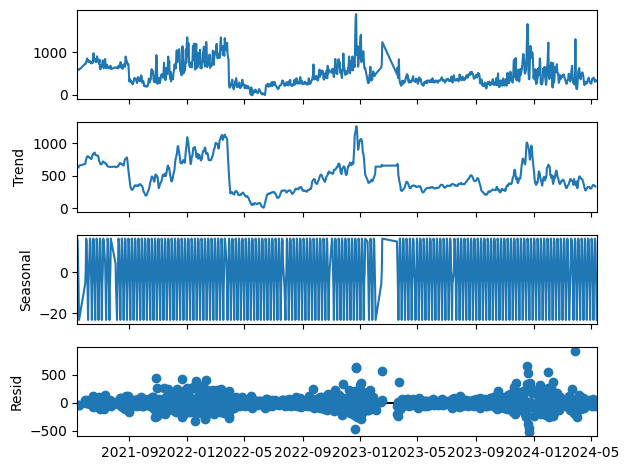

In [461]:
parameter_id = 4

decomposition = sm.tsa.seasonal_decompose(get_timeseries_data_by_parameter(df_final_source, parameter_id),
                                          model='addictive',
                                          period=7)
fig = decomposition.plot()

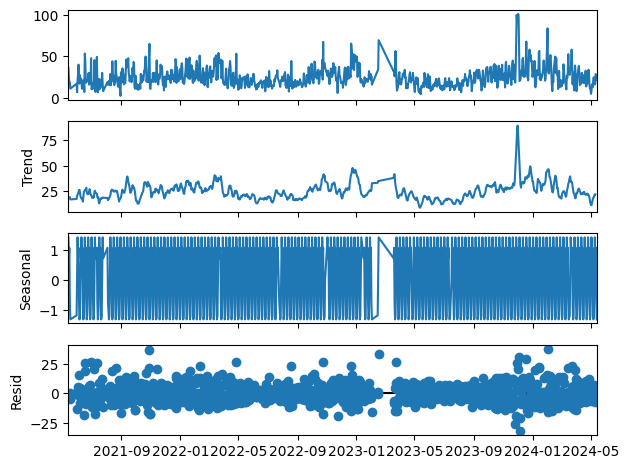

In [462]:
parameter_id = 5

decomposition = sm.tsa.seasonal_decompose(get_timeseries_data_by_parameter(df_final_source, parameter_id),
                                          model='addictive',
                                          period=7)
fig = decomposition.plot()

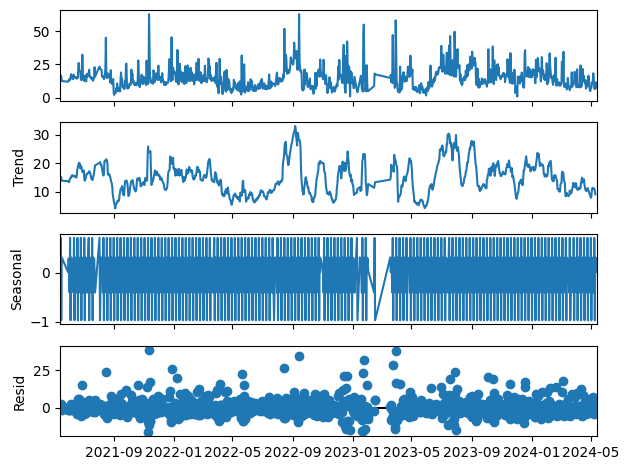

In [463]:
parameter_id = 6

decomposition = sm.tsa.seasonal_decompose(get_timeseries_data_by_parameter(df_final_source, parameter_id),
                                          model='addictive',
                                          period=7)
fig = decomposition.plot()

So we can't say with certainty that our time series has trend and seasonality characteristics. Trend is very look like with observations and isn't very straight.

During our analysis we are going to try multiple techniques to make time series stationary and record the stationarity scores for each method. Finally, we will select the method, which is easy for inverse transformation easy and give best stationarity score.

## Check for stationarity

Most time series models work under the assumption that the underlying data is stationary, that is the mean, variance, and covariance are not time-dependent. More likely than not your time series will not be stationary which means that you will have to identify the trends present in your series and manipulate the data to become stationary. After the trends are removed you can apply advanced modeling techniques while maintaining the valuable knowledge of the separated trends, which will be used later.

We are going to use rolling statistics and Dickey-Fuller test to check the stationarity of the time series

Rolling Statistics
In rolling statistics technique we define a size of window to calculate the mean and standard deviation throughout the series. For stationary series mean and standard deviation shouldn't change with time.

Augmented Dickey Fuller (ADF) Test:
ADF test will return 'p-value' and 'Test Statistics' output values.
* p-value > 0.05: non-stationary.
* p-value <= 0.05: stationary.

Test statistics:
* More negative this value more likely we have stationary series. Also, this value should be smaller than critical values(1%, 5%, 10%). For e.g. If test statistic is smaller than the 5% critical values, then we can say with 95% confidence that this is a stationary series

In [464]:
def stationarity_test(timeseries):
  '''
  Augmented Dickey Fuller (ADF) Test
  '''

  # Get rolling statistics for window = 12 i.e. yearly statistics
  rolling_mean = timeseries.rolling(window=24).mean()
  rolling_std = timeseries.rolling(window=24).std()

  # Plot rolling statistic
  plt.figure(figsize=(10,6))
  plt.xlabel('Date')
  plt.ylabel(f'Average per day {parameter_name_by_id[parameter_id]}')
  plt.title('Stationary Test: Rolling Mean and Standard Deviation')
  plt.plot(timeseries, color='blue', label='Original')
  plt.plot(rolling_mean, color='green', label='Rolling Mean')
  plt.plot(rolling_std, color='red', label='Rolling Std')
  plt.legend()
  plt.show()

  # Dickey-Fuller test
  print('Results of Dickey-Fuller Test')
  df_test = adfuller(timeseries)
  df_output = pd.Series(df_test[0:4], index = ['Test Statistic', 'p-value',
                                                 '#Lags Used',
                                                 'Number of Observations Used'])
  for key, value in df_test[4].items():
    df_output['Critical Value (%s)' %key] = value
  print(df_output)
  print('------------------------------------------')
  print('by p-value')
  if df_output['p-value'] > 0.05:
    print('> non-stationary')
  else:
    print('> stationary')

  print('------------------------------------------')
  print('by test statistics - 5%')
  if df_output['Test Statistic'] > df_output['Critical Value (5%)']:
    print('> non-stationary')
  else:
    print('> stationary')
  print('------------------------------------------')
  print('by test statistics - 1%')
  if df_output['Test Statistic'] > df_output['Critical Value (1%)']:
    print('> non-stationary')
  else:
    print('> stationary')


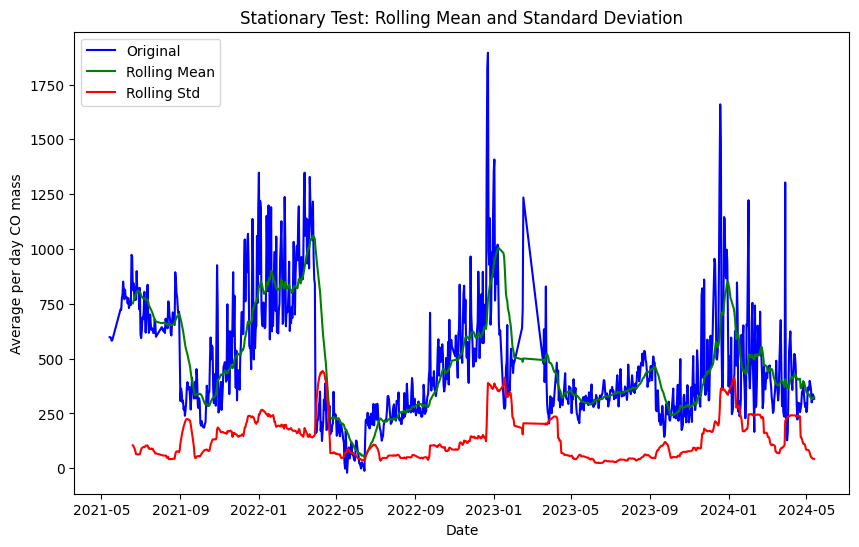

Results of Dickey-Fuller Test
Test Statistic                   -3.716635
p-value                           0.003885
#Lags Used                        7.000000
Number of Observations Used    1005.000000
Critical Value (1%)              -3.436873
Critical Value (5%)              -2.864420
Critical Value (10%)             -2.568304
dtype: float64
------------------------------------------
by p-value
> stationary
------------------------------------------
by test statistics - 5%
> stationary
------------------------------------------
by test statistics - 1%
> stationary


In [465]:
parameter_id = 4
stationarity_test(get_timeseries_data_by_parameter(df_final_source, parameter_id))

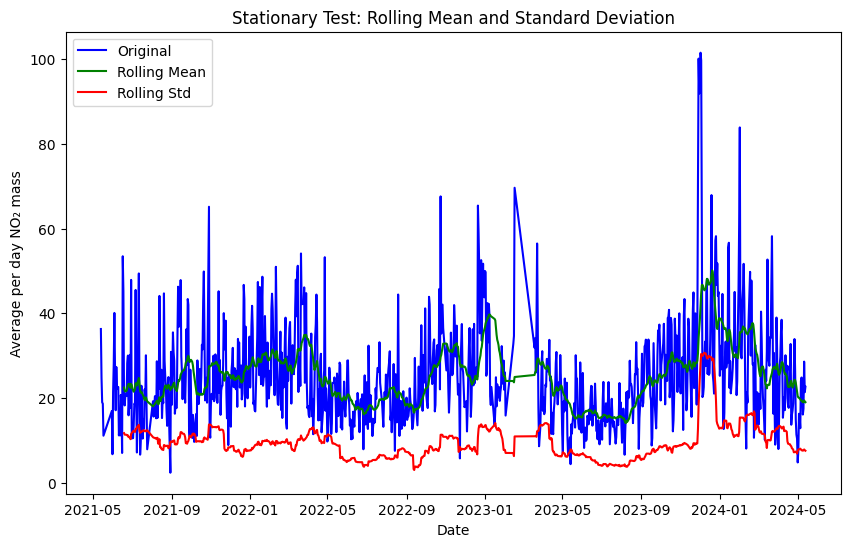

Results of Dickey-Fuller Test
Test Statistic                -7.055527e+00
p-value                        5.387790e-10
#Lags Used                     6.000000e+00
Number of Observations Used    1.006000e+03
Critical Value (1%)           -3.436867e+00
Critical Value (5%)           -2.864417e+00
Critical Value (10%)          -2.568302e+00
dtype: float64
------------------------------------------
by p-value
> stationary
------------------------------------------
by test statistics - 5%
> stationary
------------------------------------------
by test statistics - 1%
> stationary


In [466]:
parameter_id = 5
stationarity_test(get_timeseries_data_by_parameter(df_final_source, parameter_id))

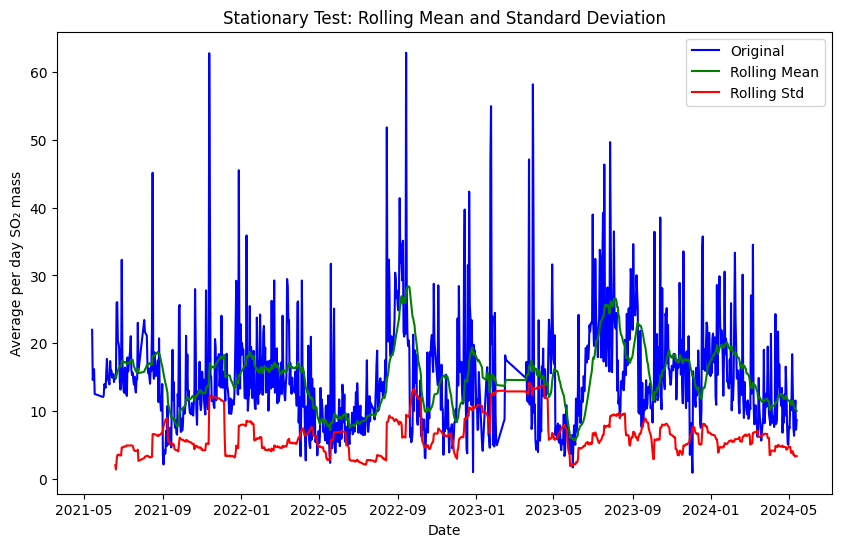

Results of Dickey-Fuller Test
Test Statistic                   -5.645152
p-value                           0.000001
#Lags Used                        8.000000
Number of Observations Used    1000.000000
Critical Value (1%)              -3.436906
Critical Value (5%)              -2.864435
Critical Value (10%)             -2.568311
dtype: float64
------------------------------------------
by p-value
> stationary
------------------------------------------
by test statistics - 5%
> stationary
------------------------------------------
by test statistics - 1%
> stationary


In [467]:
parameter_id = 6
stationarity_test(get_timeseries_data_by_parameter(df_final_source, parameter_id))

According to the test results, the data for all parameters is stationary.

# Forecasting

We will use values from `df_final_source` dataframe.

Next step, select best parameters for ARIMA model.

## ARIMA

In [205]:
pip install pmdarima --quiet

In [206]:
from pmdarima import auto_arima

We will make models for each parameter. Let's start with Carbon Monoxide (CO)

### Carbon Monoxide

In [468]:
data_carbon_monoxide = get_timeseries_data_by_parameter(df_final_source, 4)

In [496]:
# Run combinations of ARIMA(p,d,q)
model_fit = auto_arima(data_carbon_monoxide['average'],
                       test='adf',
                       D=0,
                       max_order=None,
                       max_p=7,
                       max_q=7,
                       max_d=2,
                       max_P=4,
                       max_Q=4,
                       max_D=2,
                       alpha=0.05,
                       seasonal=False,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True
                      )

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1013
Model:               SARIMAX(2, 0, 2)   Log Likelihood               -6437.599
Date:                Tue, 14 May 2024   AIC                          12887.199
Time:                        11:17:47   BIC                          12916.723
Sample:                             0   HQIC                         12898.413
                               - 1013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      6.1095      3.731      1.637      0.102      -1.204      13.423
ar.L1          1.3257      0.078     17.014      0.000       1.173       1.478
ar.L2         -0.3386      0.074     -4.555      0.000      -0.484      -0.193
ma.L1         -0.6263      0.079     -7.909      0.000      -0.781      -0.471
ma.L2         -0.1598      0.039     -4.119      0.000      -0.236      -0.084
sigma2      1.935e+04    430.399     44.964      0.000    1.85e+04    2.02e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2510.76
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.06   Skew:                             0.55
Prob(H) (two-sided):                  0.57   Kurtosis:                        10.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [497]:
model_fit

ARIMA(order=(2, 0, 2), scoring_args={}, suppress_warnings=True)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



<Axes: xlabel='day'>

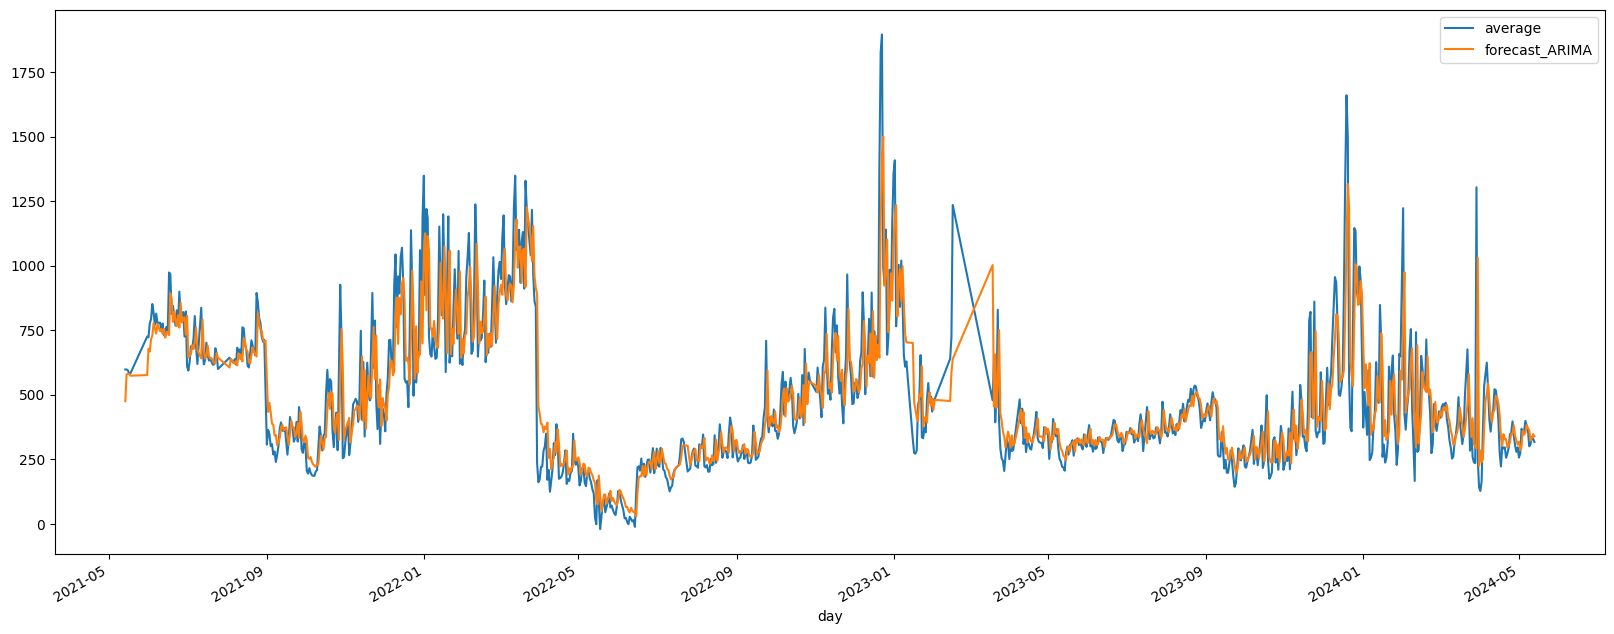

In [482]:
# Fit the ARIMA model
model_arima_carbon_monoxide = ARIMA(data_carbon_monoxide['average'],
              order=(2, 0, 2),
              seasonal_order=(0, 0, 0, 0)
            )

model_arima_carbon_monoxide = model_arima_carbon_monoxide.fit()

data_carbon_monoxide['forecast_ARIMA'] = model_arima_carbon_monoxide.predict()
data_carbon_monoxide[['average','forecast_ARIMA']].plot(figsize=(20,8))


In [483]:
mae = mean_absolute_error(data_carbon_monoxide['average'], data_carbon_monoxide['forecast_ARIMA'])
print(f'MAE of ARIMA model for Carbon monoxide: {mae:.3f}')
print('------------------------------')
rmse = np.sqrt(mean_squared_error(data_carbon_monoxide['average'], data_carbon_monoxide['forecast_ARIMA']))
print(f'RMSE of ARIMA model for Carbon monoxide: {rmse:.3f}')

MAE of ARIMA model for Carbon monoxide: 87.777
------------------------------
RMSE of ARIMA model for Carbon monoxide: 139.150


Results for carbon monoxide is okay, we just need to remember the scale of our target variable. We will plot predictions in section 'Future forecasting'

### Nitrogen dioxide

In [484]:
data_nitrogen_dioxide = get_timeseries_data_by_parameter(df_final_source, 5)

In [498]:
model_fit = auto_arima(data_nitrogen_dioxide['average'],
                       test='adf',
                       D=0,
                       max_order=None,
                       max_p=7,
                       max_q=7,
                       max_d=2,
                       max_P=4,
                       max_Q=4,
                       max_D=2,
                       alpha=0.05,
                       seasonal=False,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True
                      )

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1013
Model:               SARIMAX(2, 0, 2)   Log Likelihood               -3694.066
Date:                Tue, 14 May 2024   AIC                           7400.131
Time:                        11:18:24   BIC                           7429.656
Sample:                             0   HQIC                          7411.346
                               - 1013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4188      0.265      1.581      0.114      -0.100       0.938
ar.L1          1.4080      0.073     19.219      0.000       1.264       1.552
ar.L2         -0.4250      0.066     -6.406      0.000      -0.555      -0.295
ma.L1         -0.8258      0.080    -10.325      0.000      -0.983      -0.669
ma.L2         -0.0866      0.053     -1.635      0.102      -0.190       0.017
sigma2        84.8201      2.542     33.365      0.000      79.838      89.803
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               558.72
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.98   Skew:                             0.91
Prob(H) (two-sided):                  0.88   Kurtosis:                         6.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [499]:
model_fit

ARIMA(order=(2, 0, 2), scoring_args={}, suppress_warnings=True)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



<Axes: xlabel='day'>

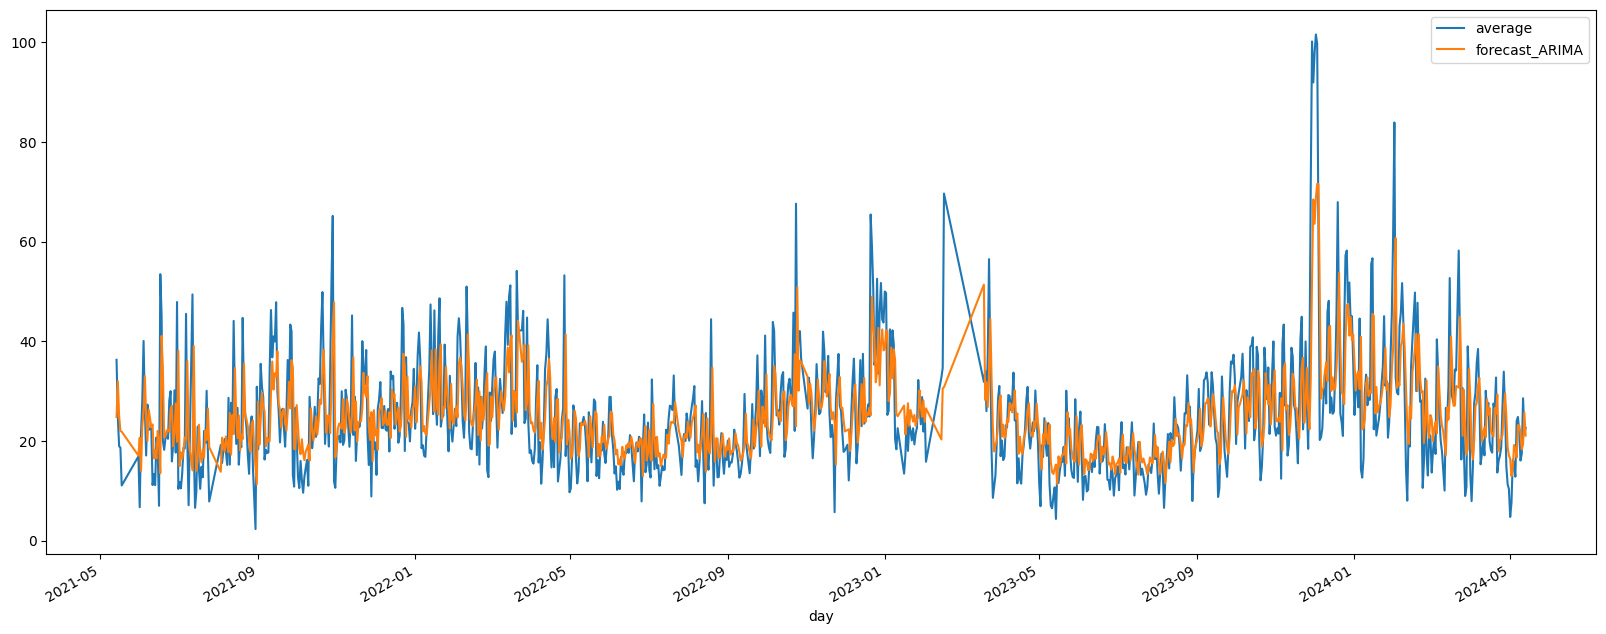

In [487]:
# Fit the ARIMA model
model_arima_nitrogen_dioxide = ARIMA(data_nitrogen_dioxide['average'],
              order=(2, 0, 2),
              seasonal_order=(0, 0, 0, 0)
            )

model_arima_nitrogen_dioxide = model_arima_nitrogen_dioxide.fit()

data_nitrogen_dioxide['forecast_ARIMA'] = model_arima_nitrogen_dioxide.predict()
data_nitrogen_dioxide[['average','forecast_ARIMA']].plot(figsize=(20,8))

In [488]:
mae = mean_absolute_error(data_nitrogen_dioxide['average'], data_nitrogen_dioxide['forecast_ARIMA'])
print(f'MAE of ARIMA model for Nitrogen dioxide: {mae:.3f}')
print('------------------------------')
rmse = np.sqrt(mean_squared_error(data_nitrogen_dioxide['average'], data_nitrogen_dioxide['forecast_ARIMA']))
print(f'RMSE of ARIMA model for Nitrogen dioxide: {rmse:.3f}')

MAE of ARIMA model for Nitrogen dioxide: 6.789
------------------------------
RMSE of ARIMA model for Nitrogen dioxide: 9.270


We got fine results on ARIMA models for Nitrogen dioxide too.

### Sulfur dioxide

In [489]:
data_sulfur_dioxide = get_timeseries_data_by_parameter(df_final_source, 6)

In [492]:
model_fit = auto_arima(data_sulfur_dioxide['average'],
                       test='adf',
                       D=0,
                       max_order=None,
                       max_p=7,
                       max_q=7,
                       max_d=2,
                       max_P=4,
                       max_Q=4,
                       max_D=2,
                       alpha=0.05,
                       seasonal=False,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True
                      )

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1009
Model:               SARIMAX(3, 0, 1)   Log Likelihood               -3359.824
Date:                Tue, 14 May 2024   AIC                           6731.649
Time:                        11:16:27   BIC                           6761.149
Sample:                             0   HQIC                          6742.856
                               - 1009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.7003      0.253      2.765      0.006       0.204       1.197
ar.L1          1.1410      0.052     21.989      0.000       1.039       1.243
ar.L2         -0.2464      0.042     -5.931      0.000      -0.328      -0.165
ar.L3          0.0582      0.032      1.821      0.069      -0.004       0.121
ma.L1         -0.7826      0.048    -16.459      0.000      -0.876      -0.689
sigma2        45.6611      1.146     39.838      0.000      43.415      47.908
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              4920.25
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.08   Skew:                             2.27
Prob(H) (two-sided):                  0.46   Kurtosis:                        12.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [493]:
model_fit

ARIMA(order=(3, 0, 1), scoring_args={}, suppress_warnings=True)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



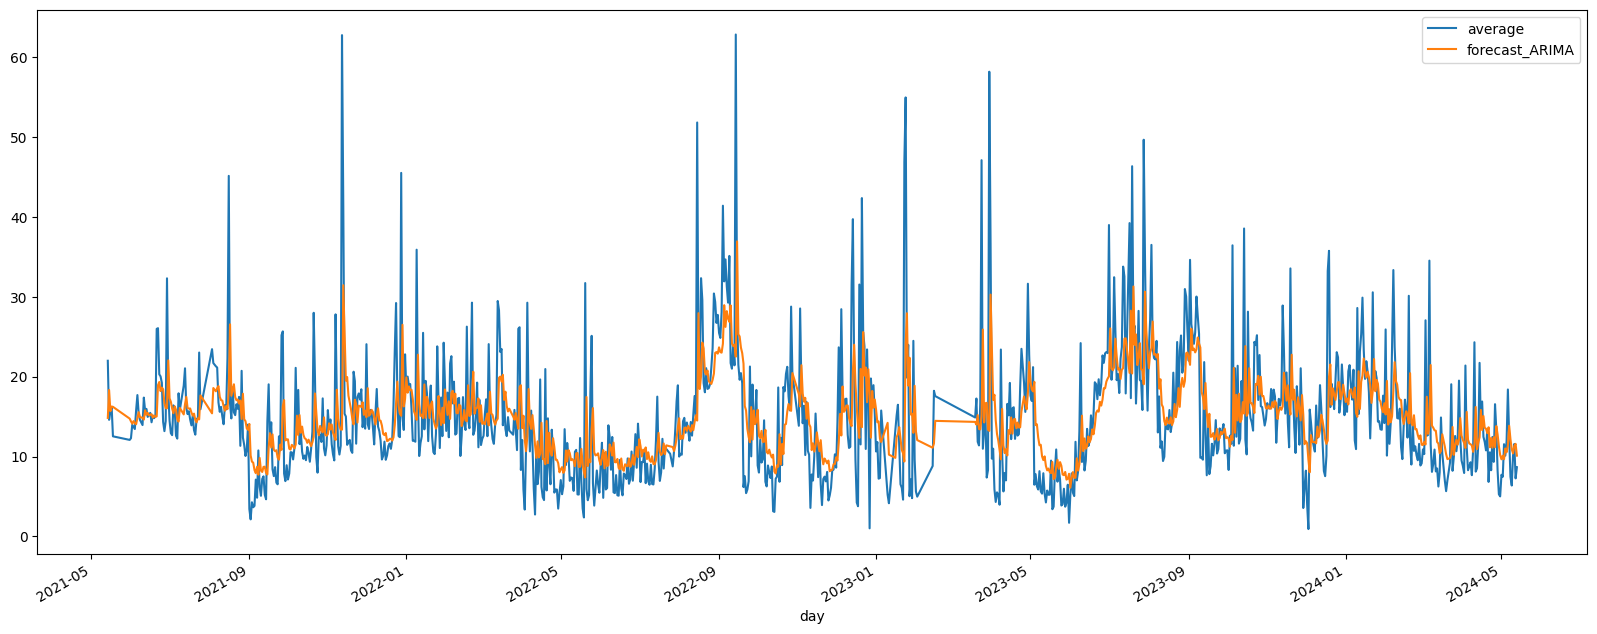

In [494]:
# Fit the ARIMA model
model_arima_sulfur_dioxide = ARIMA(data_sulfur_dioxide['average'],
              order=(3, 0, 1),
              seasonal_order=(0, 0, 0, 0)
            )

model_arima_sulfur_dioxide = model_arima_sulfur_dioxide.fit()

data_sulfur_dioxide['forecast_ARIMA'] = model_arima_sulfur_dioxide.predict()
data_sulfur_dioxide[['average','forecast_ARIMA']].plot(figsize=(20,8))
plt.show()

In [495]:
mae = mean_absolute_error(data_sulfur_dioxide['average'], data_sulfur_dioxide['forecast_ARIMA'])
print(f'MAE of ARIMA model for Sulfur dioxide: {mae:.3f}')
print('------------------------------')
rmse = np.sqrt(mean_squared_error(data_sulfur_dioxide['average'], data_sulfur_dioxide['forecast_ARIMA']))
print(f'RMSE of ARIMA model for Sulfur dioxide: {rmse:.3f}')

MAE of ARIMA model for Sulfur dioxide: 4.470
------------------------------
RMSE of ARIMA model for Sulfur dioxide: 6.759


For Sulfur dioxide we got decent results, but it could be better.

## Future forecasting

This section is all about making predictions based on models from previous section. We will plot predictions using red color to add contrast.

The prediction is for 90 steps in our case 90 days = 3 months.

### Carbon monoxide

In [545]:
table = model_arima_carbon_monoxide.forecast(steps=90)
table.index = pd.date_range(start='2024-05-07', periods=90)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



In [546]:
prediction_carbon_monoxide = pd.DataFrame(table)
prediction_carbon_monoxide.columns=['prediction']

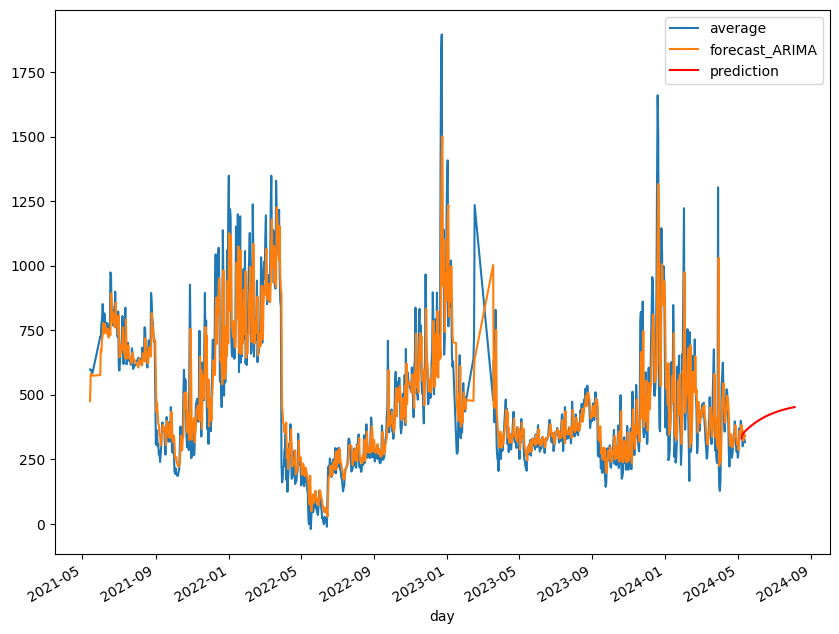

In [547]:
fig, ax = plt.subplots(figsize=(10, 8))
ax = data_carbon_monoxide.loc['2021':].plot(ax=ax)
ax = prediction_carbon_monoxide['prediction'].plot(ax=ax, color='red', label='prediction')
plt.legend()
plt.show()

In [548]:
prediction_carbon_monoxide.head()

,prediction
2024-05-07,331.426892
2024-05-08,341.683122
2024-05-09,346.865772
2024-05-10,350.261624
2024-05-11,353.008104


### Nitrogen dioxide

In [549]:
table = model_arima_nitrogen_dioxide.forecast(steps=90)
table.index = pd.date_range(start='2024-05-07', periods=90)
prediction_nitrogen_dioxide = pd.DataFrame(table)
prediction_nitrogen_dioxide.columns=['prediction']

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



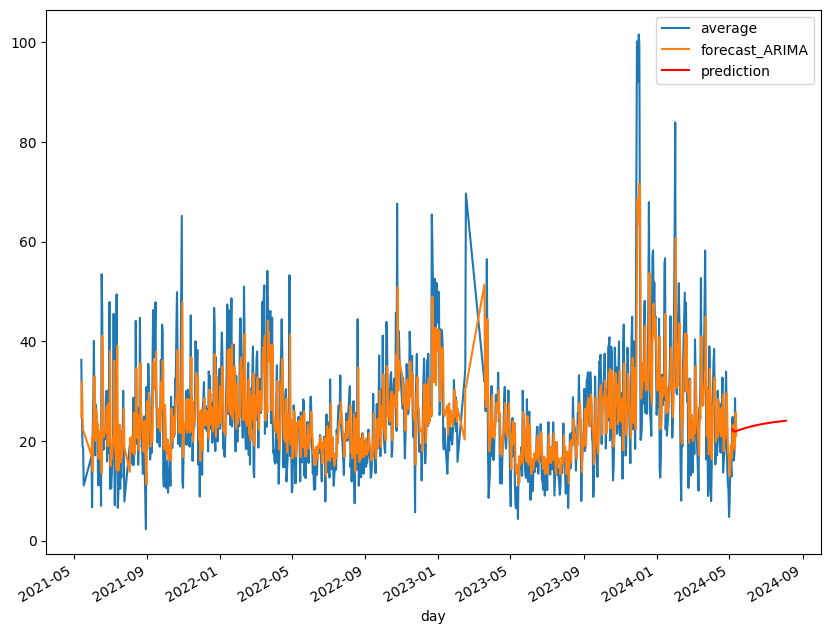

In [550]:
fig, ax = plt.subplots(figsize=(10, 8))
ax = data_nitrogen_dioxide.loc['2021':].plot(ax=ax)
ax = prediction_nitrogen_dioxide['prediction'].plot(ax=ax, color='red', label='prediction')
plt.legend()
plt.show()

In [551]:
prediction_nitrogen_dioxide.head()

,prediction
2024-05-07,22.277173
2024-05-08,22.003734
2024-05-09,21.908006
2024-05-10,21.891168
2024-05-11,21.909128


### Sulfur dioxide

In [552]:
table = model_arima_sulfur_dioxide.forecast(steps=90)
table.index = pd.date_range(start='2024-05-07', periods=90)
prediction_sulfur_dioxide = pd.DataFrame(table)
prediction_sulfur_dioxide.columns=['prediction']

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



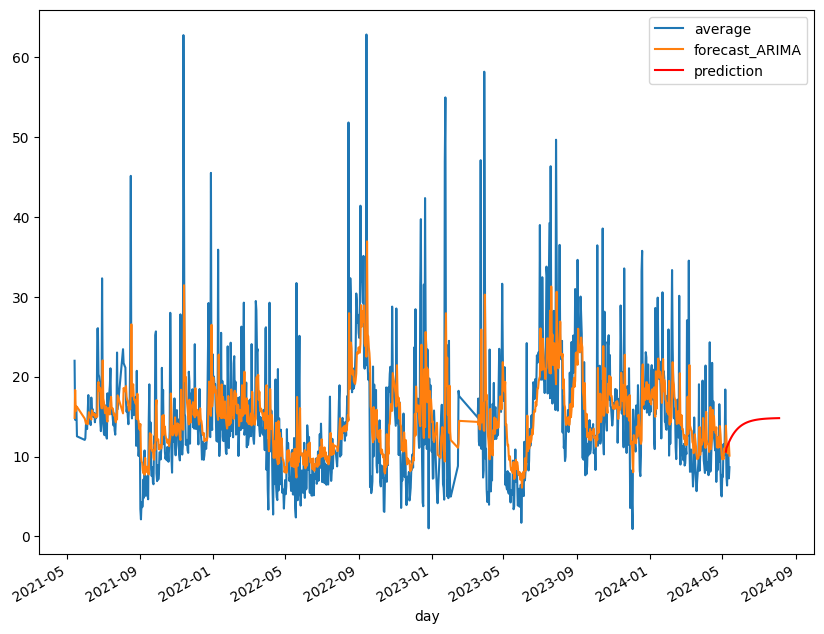

In [553]:
fig, ax = plt.subplots(figsize=(10, 8))
ax = data_sulfur_dioxide.loc['2021':].plot(ax=ax)
ax = prediction_sulfur_dioxide['prediction'].plot(ax=ax, color='red', label='prediction')
plt.legend()
plt.show()

In [554]:
prediction_sulfur_dioxide.head()

,prediction
2024-05-07,10.608721
2024-05-08,11.091082
2024-05-09,11.245912
2024-05-10,11.416514
2024-05-11,11.601109


## Final dataset

Let's create Dataframe with all results that we got and let's save it to .csv format.

In [555]:
prediction_carbon_monoxide = prediction_carbon_monoxide.reset_index().rename(columns={'index':'date'})
prediction_carbon_monoxide.head()

,date,prediction
0,2024-05-07,331.426892
1,2024-05-08,341.683122
2,2024-05-09,346.865772
3,2024-05-10,350.261624
4,2024-05-11,353.008104


In [556]:
prediction_nitrogen_dioxide = prediction_nitrogen_dioxide.reset_index().rename(columns={'index':'date'})
prediction_nitrogen_dioxide.head()

,date,prediction
0,2024-05-07,22.277173
1,2024-05-08,22.003734
2,2024-05-09,21.908006
3,2024-05-10,21.891168
4,2024-05-11,21.909128


In [557]:
prediction_sulfur_dioxide = prediction_sulfur_dioxide.reset_index().rename(columns={'index':'date'})
prediction_sulfur_dioxide.head()

,date,prediction
0,2024-05-07,10.608721
1,2024-05-08,11.091082
2,2024-05-09,11.245912
3,2024-05-10,11.416514
4,2024-05-11,11.601109


In [563]:
predictions = prediction_carbon_monoxide.merge(prediction_nitrogen_dioxide,
                                               on='date')

In [564]:
predictions = predictions.merge(prediction_sulfur_dioxide,
                                on='date')

In [568]:
predictions = predictions.rename(columns={'prediction_x':'carbon_monoxide',
                                  'prediction_y':'nitrogen_dioxide',
                                  'prediction':'sulfur_dioxide'})
predictions

,date,carbon_monoxide,nitrogen_dioxide,sulfur_dioxide
0,2024-05-07,331.426892,22.277173,10.608721
1,2024-05-08,341.683122,22.003734,11.091082
2,2024-05-09,346.865772,21.908006,11.245912
3,2024-05-10,350.261624,21.891168,11.416514
4,2024-05-11,353.008104,21.909128,11.601109
...,...,...,...,...
85,2024-07-31,450.320825,23.998456,14.805396
86,2024-08-01,450.801318,24.011212,14.807285
87,2024-08-02,451.272410,24.023769,14.809070
88,2024-08-03,451.734285,24.036129,14.810759


In [562]:
# save dataframe to .csv format
predictions.to_csv('predictions_air_quality_europe.csv', index=False)

# Conclusion

We have successfully achieved the project goals and projected air quality indicators for the city of Belgrade, Serbia, for the next three months. The code can also be applied to other cities by simply changing the location ID.

Inspo:

https://www.kaggle.com/code/shilongzhuang/advanced-time-series-forecasting-with-python

https://www.kaggle.com/code/satishgunjal/tutorial-time-series-analysis-and-forecasting#Python-Example-